# Identifying Fraud from Enron Email

## Yong Yu

This is a report on the process of builing estimators for Fraud Detection using machine learning.

A more compact and summarized report can be found [here](http://yyforyongyu.s3-website-us-east-1.amazonaws.com/projects/enron_fraud_summary.html) or this [notebook documentation](https://github.com/yyforyongyu/fraud-detection-enron/blob/master/main/documentation.ipynb).

---

## Overview
In this report, there are series of investigations performed to make a robust, strong final estimator to predict a person-of-interest(poi). These include,
- an overview of the dataset.
- outlier cleaning.
- a performance comparison among different feature scaling methods, including MinMaxScaler, StandardScaler, and Normalizer.
- creating three features, "stock_salary_ratio", "poi_from_ratio", "poi_to_ratio", and evaluating them.
- a performance comparison between two different feature selection methods, SelectKBest and ExtraTreesClassifier.
- a performance comparison between including PCA and excluding PCA.
- a performance comparison between different classifiers, LinearSVC and KNeighborsClassifier.
- tuning algorithms using F1 score as evaluation metric.
- cross-validation on the final estimator.

Several helper functions are built for this project in poi_helper.py. Since this report only focuses on methodology in machine learning, we will not cover them here. For more details, report 
[poi_id.ipynb](https://github.com/yyforyongyu/fraud-detection-enron/blob/master/main/poi_id.ipynb)
has all the thoughts and steps in building these functions.

## Methodology
When finding a best combination out of groups of factors, there are usually two ways to think about it. One way would be simply find the best solution from each group, then chain all the solutions together to make the final combination. The assumption is that the best of each independent thing can be grouped to be the best of a new thing. In reality, this is rarely true since the best from one group might have a negtive effect on the best from another group. If we are to apply this method into the analysis, in short, we would need to first, find the best feature selection method, then find the best calssifier, lastly combine the feature selection and classifier to make the final estimator. However, from the report [poi_id.ipynb](https://github.com/yyforyongyu/fraud-detection-enron/blob/master/main/poi_id.ipynb),
using a SelectKBest + LinearSVC could have an accuracy score of 0.94, same when using RandomizedLogisticRegression + KNeighbors, although the runtimes were different. However, when applying RandomizedLogisticRegression + LinearSVC, or SelectKBest + KNeighbors, accuracy scores became lower. This clearly indicates that, for each classifier algorithm, there is a best fit feature selection method. Simply chaining a best classifier and a feature selection seperately won't produce the best result. It becomes rather clear when all the algorithms were applied on both outlier-cleaned and full datasets. The best estimator for one dataset won't work on a different dataset.

So machine learning is really about finding a specific, nearly unique solution to a question, which brings me to think about the second way, exhaustively trying out combinations of all factors, rather than finding a best answer by groups. This assumes that a simple change in one unit can make a total difference. Unfortunately, this method also creates a problem, large time consumptions.

For this analysis, the dataset will be tested with or without PCA, with four feature scaling methods(including not using one), with two feature selection methods, and two classifiers, considering only 20 values to be tuned on each classifier, 20 values to be tuned on each feature selection, and 10 values to be tuned on PCA, a rough total number of combinations is,
$$ 2*4*2*2*20*20*10 = 128,000$$
And it is not likely we will conduct all the possibilies here at once, we will have to make a tradeoff.

For this analysis, the parameters of feature selection methods won't be tuned untill one best feature selection method is found, then the cross validation will be tuned, which brings the possible combination down dramstically before we start to tune on feature selection and cross validation.

# Summary of Dataset
A summary of findings,
- there are 146 data points with 21 features, and a total of 3066 obervations.
- there are 18 people who is an point of interest.
- 1,358 data points are missing.
- the top 3 features with most missing values are "loan_advances", "director_fees", and "restricted_stock_deferred".

In [1]:
#!/usr/bin/python

import sys
import pickle
from tester import dump_classifier_and_data, test_classifier
sys.path.append("../tools/")
from poi_helper import *

### Load the dictionary containing the dataset
data_dict = pickle.load(open("final_project_dataset.pkl", "r") )

In [2]:
# number of data points
len(data_dict.keys())

146

In [3]:
# number of features available
len(data_dict['METTS MARK'])

21

In [4]:
# available features
data_dict["METTS MARK"].keys()

['salary',
 'to_messages',
 'deferral_payments',
 'total_payments',
 'exercised_stock_options',
 'bonus',
 'restricted_stock',
 'shared_receipt_with_poi',
 'restricted_stock_deferred',
 'total_stock_value',
 'expenses',
 'loan_advances',
 'from_messages',
 'other',
 'from_this_person_to_poi',
 'poi',
 'director_fees',
 'deferred_income',
 'long_term_incentive',
 'email_address',
 'from_poi_to_this_person']

In [5]:
# people of interest
count = 0
for key, item in data_dict.iteritems():
    if item["poi"]:
        print key
        count += 1
count

HANNON KEVIN P
COLWELL WESLEY
RIEKER PAULA H
KOPPER MICHAEL J
SHELBY REX
DELAINEY DAVID W
LAY KENNETH L
BOWEN JR RAYMOND M
BELDEN TIMOTHY N
FASTOW ANDREW S
CALGER CHRISTOPHER F
RICE KENNETH D
SKILLING JEFFREY K
YEAGER F SCOTT
HIRKO JOSEPH
KOENIG MARK E
CAUSEY RICHARD A
GLISAN JR BEN F


18

In [6]:
# create a dictionary for all missing values
missing = {}
for key, item in data_dict.iteritems():
    for elem, value in item.iteritems():
        if value == "NaN":
            if elem not in missing:
                missing[elem] = 1
            else:
                missing[elem] += 1

In [7]:
# number of missing values
number_of_missing = 0
for key, item in missing.iteritems():
    number_of_missing += item
number_of_missing

1358

In [8]:
missing

{'bonus': 64,
 'deferral_payments': 107,
 'deferred_income': 97,
 'director_fees': 129,
 'email_address': 35,
 'exercised_stock_options': 44,
 'expenses': 51,
 'from_messages': 60,
 'from_poi_to_this_person': 60,
 'from_this_person_to_poi': 60,
 'loan_advances': 142,
 'long_term_incentive': 80,
 'other': 53,
 'restricted_stock': 36,
 'restricted_stock_deferred': 128,
 'salary': 51,
 'shared_receipt_with_poi': 60,
 'to_messages': 60,
 'total_payments': 21,
 'total_stock_value': 20}

# Outlier Investigation

As we already known in mini projects, there is an outlier named "TOTAL" in this dataset. We will need to remove it before any further analysis.

In [9]:
# remove the outlier 'TOTAL'
data_dict.pop("TOTAL")

{'bonus': 97343619,
 'deferral_payments': 32083396,
 'deferred_income': -27992891,
 'director_fees': 1398517,
 'email_address': 'NaN',
 'exercised_stock_options': 311764000,
 'expenses': 5235198,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 83925000,
 'long_term_incentive': 48521928,
 'other': 42667589,
 'poi': False,
 'restricted_stock': 130322299,
 'restricted_stock_deferred': -7576788,
 'salary': 26704229,
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 309886585,
 'total_stock_value': 434509511}

## Plots of the Outliers

To understand the outliers in this dataset, plots are created by using salary against every other feature but poi, which is used to color data points in each plot. As a starting point, all the available features will be selected and put into the model. Later in this report, some features will be removed based on their feature selection score.

In [10]:
# create features for plots
# features_list is a list of strings, each of which is a feature name.
# The first feature must be "poi".
features_list = ['poi',
                 'salary',
                 'to_messages',
                 'deferral_payments',
                 'total_payments',
                 'exercised_stock_options',
                 'bonus',
                 'restricted_stock',
                 'shared_receipt_with_poi',
                 'restricted_stock_deferred',
                 'total_stock_value',
                 'expenses',
                 'loan_advances',
                 'from_messages',
                 'other',
                 'from_this_person_to_poi',
                 'director_fees',
                 'deferred_income',
                 'long_term_incentive',
                 'from_poi_to_this_person']

# format the dataset
data = featureFormat(data_dict, features_list)

# create a pandas dataframe
df = pd.DataFrame(data, columns = features_list)

In the following plots, blue color stands for poi, red color stands for non-poi.

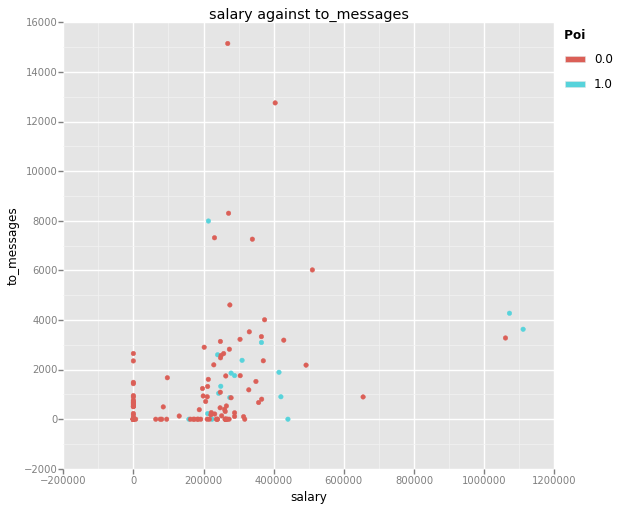

<ggplot: (281797349)>


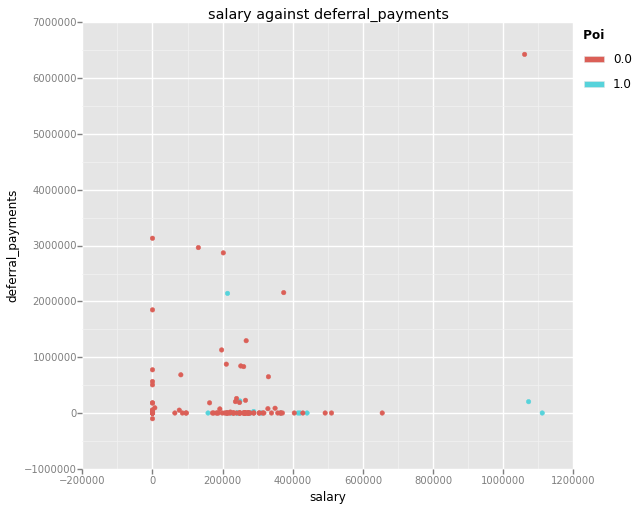

<ggplot: (279932309)>


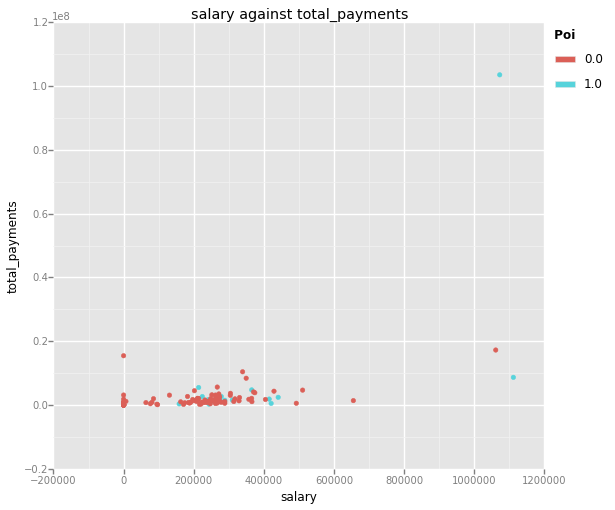

<ggplot: (279909173)>


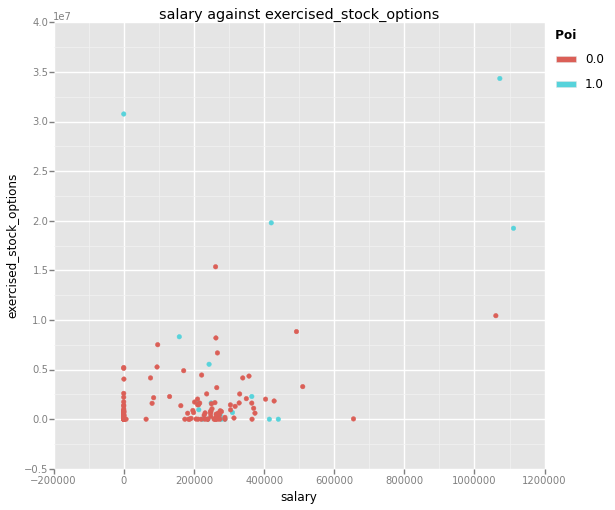

<ggplot: (279885321)>


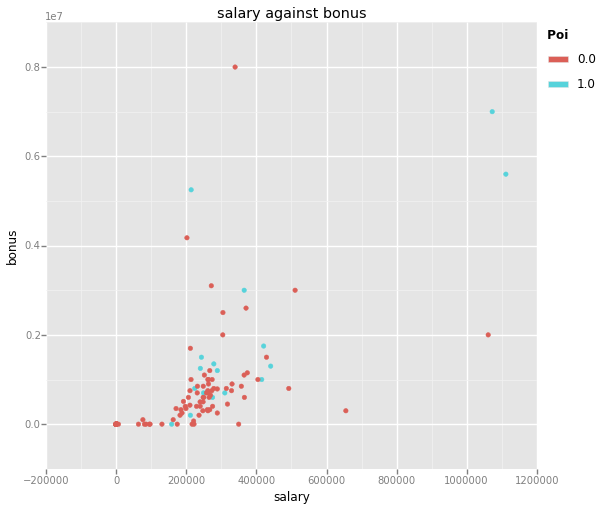

<ggplot: (279883357)>


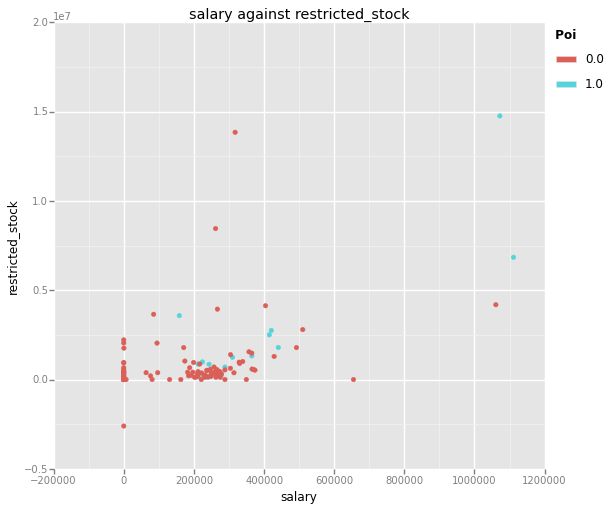

<ggplot: (272131021)>


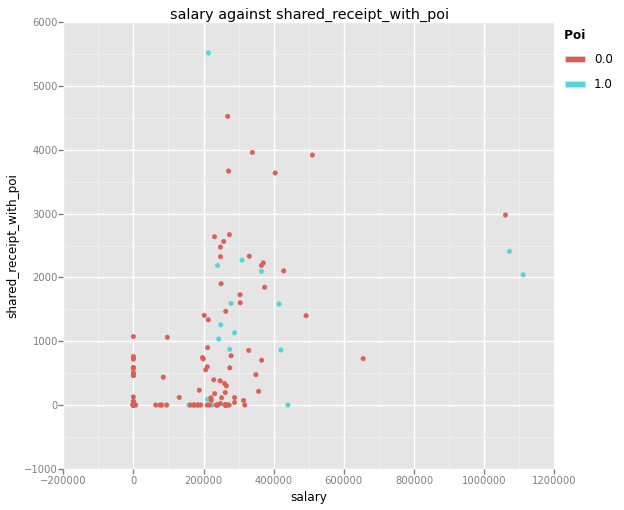

<ggplot: (279475321)>


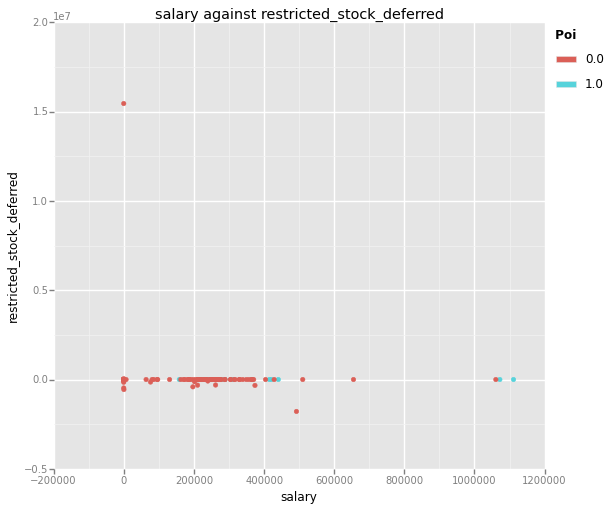

<ggplot: (279880041)>


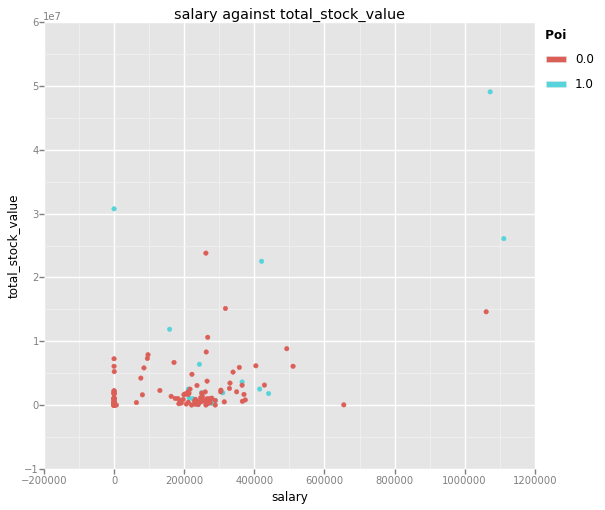

<ggplot: (279798533)>


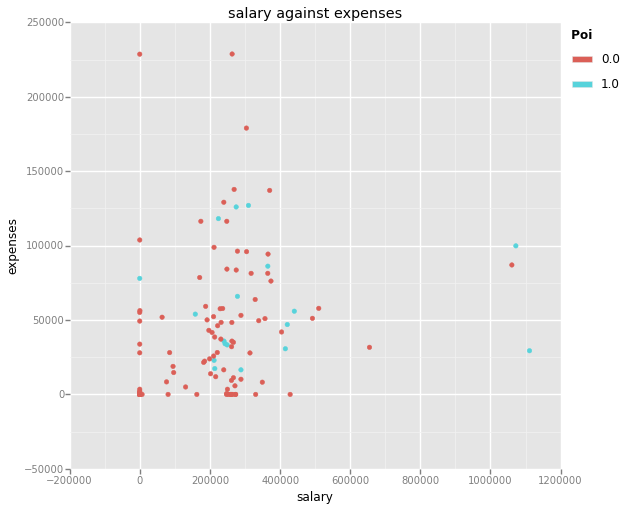

<ggplot: (271190081)>


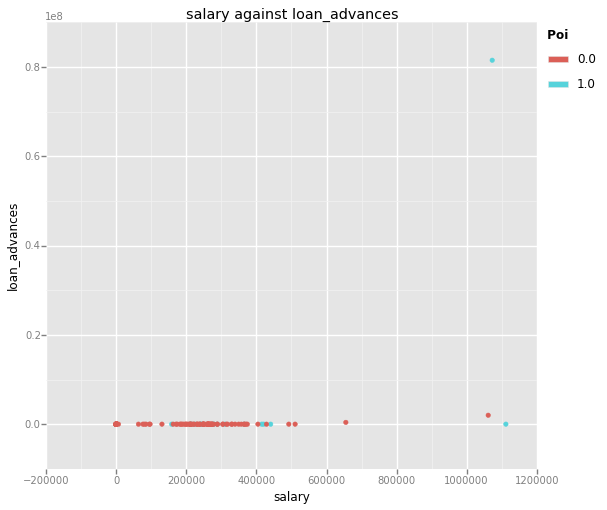

<ggplot: (279991457)>


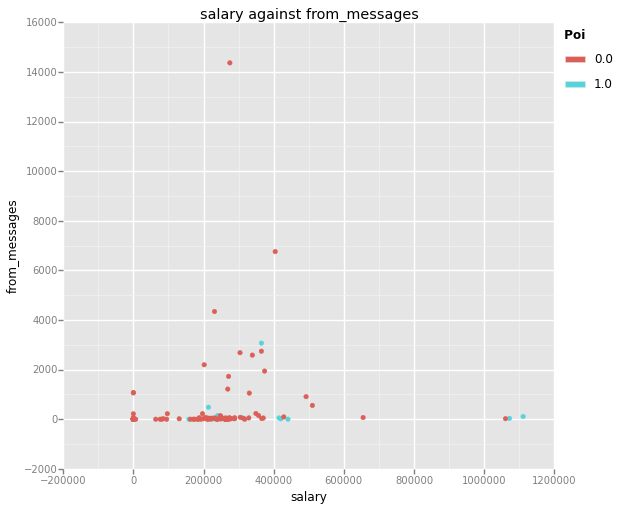

<ggplot: (271190197)>


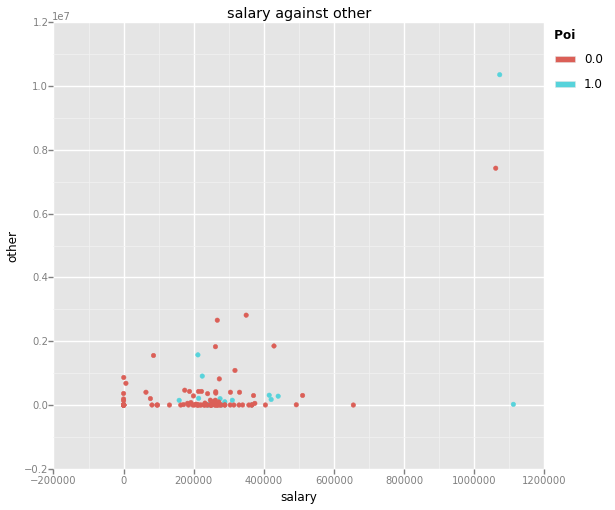

<ggplot: (279880333)>


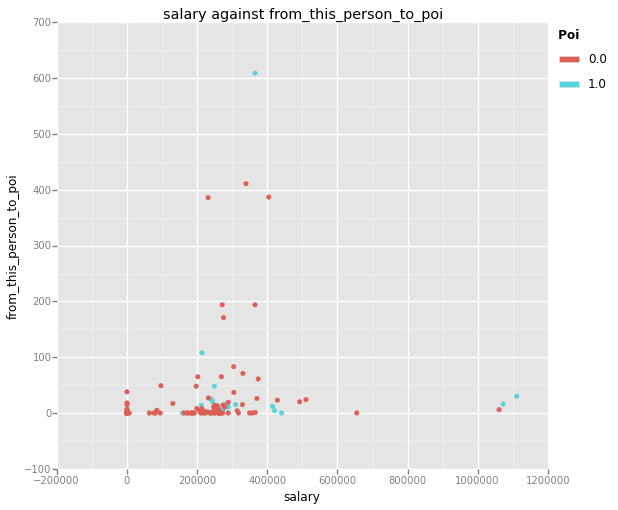

<ggplot: (279473377)>


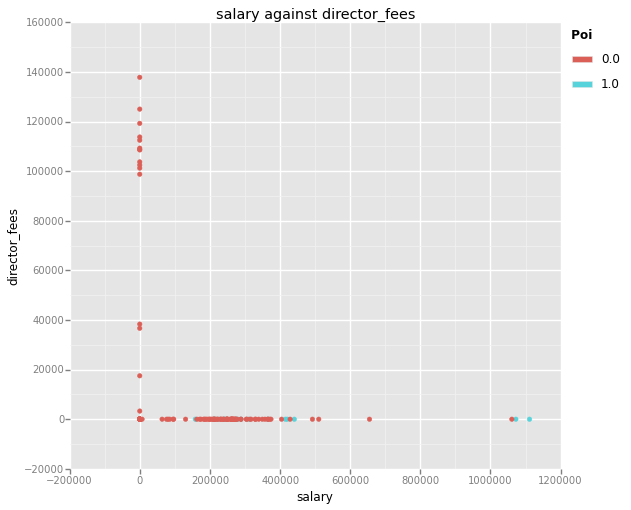

<ggplot: (279476245)>


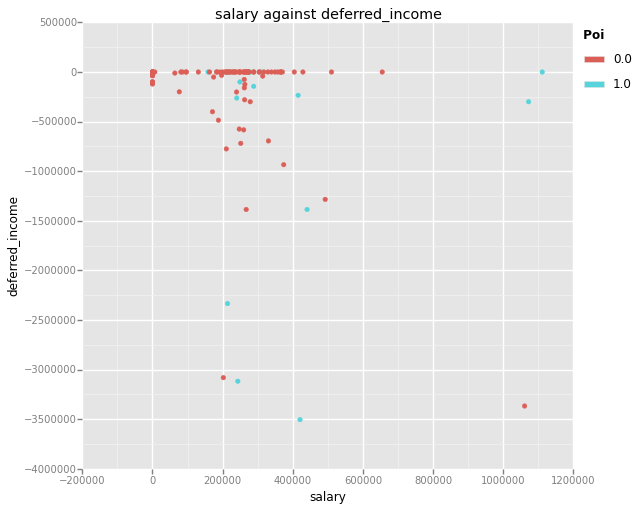

<ggplot: (279482105)>


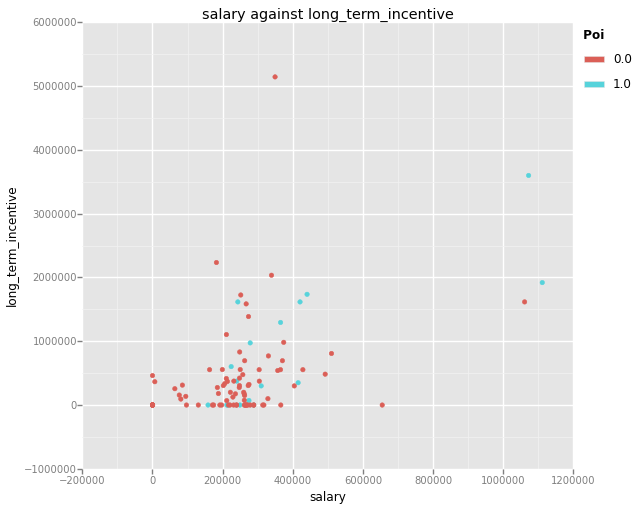

<ggplot: (279827517)>


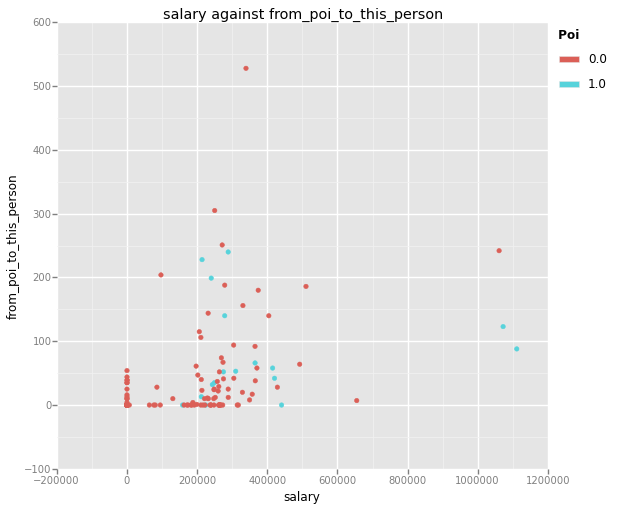

<ggplot: (280141353)>


In [11]:
%matplotlib inline
from ggplot import *

# iter through all features
# x axis will always be salary
# poi is represented by colors of points
# the rest of features are put in y axis
for feature in features_list:
    if feature != "poi" and feature != "salary":
        print ggplot(aes(x = 'salary', y = feature, color = 'poi'),
               data = df) +\
        geom_point() +\
        ggtitle("salary against " + feature)

## Outlier Removal

The purpose of removing outliers is to prevent the model being misrepresented by extreme cases, which comes with an assumption that either the extreme cases rarely happen, or they don't carry engough valuable infomration to be kept in the model. This can be true for some of the features, but could be controversy for "total_payment" feature, and shouldn't be applied to "exercised_stock_options" as the top four outliers are all person of interest. On the other hand, if we are to treat top 10% of each feature as outliers, it is not hard to imagine that the final dataset will have much less than 90%. A large deduction in the original dataset will cause the model becoming weaker.

Given all these thoughts, we will start the cleaning experiment using a simple method. By fitting in a linear regression model, we will calculate the variance between the predicted values and true values, then treat features whoes predictions have top 10% variance as outliers. Based on that, we can then decide what to do with the outliers.


In [12]:
### check on the score before outlier cleaning
features, labels = featureLabelSplit(data_dict, features_list)
buildRegression(features, labels)[1]

0.35600464626660311

In [13]:
### clean the outliers
### extract normal data points and outliers
cleaned_data, outliers = outlierCleaner(features, labels)

In [14]:
### extract labels and features from cleaned_data
cleaned_labels, cleaned_features = targetFeatureSplit(cleaned_data)

# fit the model again and check the score
buildRegression(cleaned_features, cleaned_labels)[1]

0.82103305215836841

A removal of the outliers improved the score of the linear model dramastically from 0.35 to 0.82. Although it's good to see improvement in score, it's always necessary to take a look at the removed outliers.

## Check on Outliers

In [15]:
### change the data format from numpy array to python dictionary
outliers_dataset = personMapping(featureReformat(outliers, features_list), data_dict, features_list)

In [16]:
### number of outliers
len(outliers_dataset)

14

In [17]:
### name of outliers who is not a poi
for key, item in outliers_dataset.iteritems():
    if item['poi'] == 0.0:
        print key

LAVORATO JOHN J


## Strategy on Outlier Removal

As mentioned above, simply removing the outliers might cause an issue for later on analysis. While the imporvement in score of the linear model is surely tempting, do note that, this is not the model that we will use to conduct machine learning in this dataset. 

On the other hand, there's no surprising that most of the person of interest(13 out 18) are flagged as outliers given the background knowledge of Enron Fraud. In this case, the outliers are the targets we want to find, according to <a href='https://discussions.udacity.com/t/outlier-removal/7446' target='_blank'>this post in discussion forum</a>, we can manually decided to include or exclude the outliers or not in the training set. This strategy will be applied when processing the dataset.

Given the though above, when fitting in datasets later, there are 5% outliers cleaned on the training set.

# Preprocessing Features

## Feature Creation
To dig out more patterns from the dataset, three new features, "stock_salary_ratio", "poi_from_ratio", "poi_to_ratio", are created as following.

- stock_salary_ratio: stock_salary_ratio takes the result from total_stock_value divided by salary. This feature is useful based on the assumption that a person of interest usually has a unusual large stock value since it's under the table, while salary information could be more easily known by public, thus the ratio could give information to identify the poi. The bigger the ratio, the more likely it is a poi.
- poi_from_ratio: poi_from_ratio takes result from from_poi_to_this_person divided by from_messages. This feature assumes that if a person is a poi, he/she tends to have more contacts with another poi, therefore the ratio would be bigger. And same applie to feature poi_to_ratio.

In [18]:
### add new features to dataset
for key, item in data_dict.iteritems():
    ### add stock_salary_ratio
    if item['salary'] != "NaN" and item['total_stock_value'] != "NaN":
        item['stock_salary_ratio'] = float(item['total_stock_value']) / item['salary']
    else:
        item['stock_salary_ratio'] = "NaN"
    
    ### add poi_from_ratio
    if item['from_messages'] != "NaN" and item['from_poi_to_this_person'] != "NaN":
        item['poi_from_ratio'] = float(item['from_poi_to_this_person']) / item['from_messages']
    else:
        item['poi_from_ratio'] = "NaN"
        
    ### add poi_to_ratio
    if item["to_messages"] != "NaN" and item["from_this_person_to_poi"] != "NaN":
        item["poi_to_ratio"] = float(item["from_this_person_to_poi"]) / item["to_messages"]
    else:
        item["poi_to_ratio"] = "NaN"

In [19]:
### update features list
new_features_list = features_list + ["stock_salary_ratio", "poi_from_ratio", "poi_to_ratio"]

## Feature Scaling

Depending on the algorithms chosen, feature scaling may be necessary. In this report, three feature scaling methods are compared, including MinMaxScaler, StandardScaler, and Normalizer.

In [20]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

In [21]:
stdMeanReader(features, features_list)

,feature,mean,std
3,total_payments,2259057.1250,8846594.3829
11,loan_advances,582812.5000,6794471.7789
9,total_stock_value,2909785.6111,6189018.0750
4,exercised_stock_options,2075801.9792,4795513.1452
6,restricted_stock,868536.2917,2016572.3887
8,restricted_stock_deferred,73417.9028,1301983.3904
5,bonus,675997.3542,1233155.2559
13,other,297260.0903,1131068.1310
2,deferral_payments,222089.5556,754101.3026
17,long_term_incentive,336957.8333,687182.5677


In [22]:
### check results from MinMaxScaler
stdMeanReader(features, features_list, MinMaxScaler())

,feature,mean,std
15,director_fees,0.0724,0.2270
10,expenses,0.1546,0.1981
7,shared_receipt_with_poi,0.1273,0.1951
0,salary,0.1669,0.1773
16,deferred_income,0.9447,0.1729
5,bonus,0.0845,0.1541
1,to_messages,0.0818,0.1477
18,from_poi_to_this_person,0.0734,0.1407
4,exercised_stock_options,0.0604,0.1396
17,long_term_incentive,0.0655,0.1336


In [23]:
### check results from StandardScaler
stdMeanReader(features, features_list, StandardScaler())

,feature,mean,std
0,salary,0,1.0035
10,expenses,-0,1.0035
17,long_term_incentive,0,1.0035
16,deferred_income,0,1.0035
15,director_fees,-0,1.0035
14,from_this_person_to_poi,0,1.0035
13,other,-0,1.0035
12,from_messages,-0,1.0035
11,loan_advances,-0,1.0035
9,total_stock_value,0,1.0035


In [24]:
### check results from Normalizer
stdMeanReader(features, features_list, Normalizer())

,feature,mean,std
3,total_payments,0.4200,0.3071
9,total_stock_value,0.4611,0.2800
4,exercised_stock_options,0.2979,0.2644
5,bonus,0.1587,0.1891
6,restricted_stock,0.1812,0.1890
15,director_fees,0.0520,0.1760
16,deferred_income,-0.0690,0.1638
2,deferral_payments,0.0466,0.1395
13,other,0.0506,0.1201
17,long_term_incentive,0.0693,0.1118


In [25]:
### create scalers
scalers = [('none', None),
           ('standardscaler', StandardScaler()),
           ('minmaxscaler', MinMaxScaler()),
           ('normalier', Normalizer())]

## Feature Selection

To get a better processing before any fitting into models, two feature selection methods for classification listed in 
<a href='http://scikit-learn.org/stable/modules/feature_selection.html' target='_blank'>sklearn documentations</a> 
are explored, which are SelectKBest and ExtraTreesClassifier.

In [26]:
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import ExtraTreesClassifier

feature_selections = [('k_best', SelectKBest(k = 'all')),
                     ('extra_tree', ExtraTreesClassifier(class_weight='auto', random_state=42))]

## PCA
PCA is imported to conduct dimensions deduction. Depending on the performances, the decision to include PCA or not will be made later.

In [27]:
from sklearn.decomposition import PCA
pca = [('none', None),
       ('pca', PCA())]

# Pick and Prepare Classifiers

According to 
<a href='http://scikit-learn.org/stable/tutorial/machine_learning_map/' target='_blank'>this cheat sheet in sklearn</a>, 
there are at least four classification methods can be used,
- LinearSVC
- KNeighbors Classifier
- SVC
- Ensemble Classifers

In this report, we will check on LinearSVC and KNeighborsClassifier.

In [28]:
from sklearn.svm import LinearSVC
linear_svc = LinearSVC(class_weight='auto', penalty='l1', dual=False, random_state=42)

params_svc = {'linear_svc__C':[0.01, 0.03, 0.1, 0.3, 1, 3, 10],
              'linear_svc__tol': [1e-4, 1e-3, 1e-2, 1e-1, 1],
              'linear_svc__max_iter': [1e3, 1e4]}

In [29]:
from sklearn.neighbors import KNeighborsClassifier
k_neighbors = KNeighborsClassifier(weights='distance', algorithm='auto')

params_kneighbors = {'k_neighbors__n_neighbors': [1, 3, 10],
                     'k_neighbors__leaf_size': [2, 5, 10, 30, 50, 100]}

In [30]:
### put all classifiers together
classifiers = [('linear_svc', linear_svc, params_svc),
               ('k_neighbors', k_neighbors, params_kneighbors)]

# Validation and Evaluation


## Validation
To prevent overfitting, a cross validation is needed to split the dataset into training and testing. StratifiedShuffleSplit is used across all tuning processes with a default test_size of 0.1. Depending on different steps, the n_iter paramter used for cross validation varies, as listed below,

- when finding best combination of feature selection and classification method, n_iter = 100;
- when tuning on the chosen estimator, n_iter = 1000;
- when tuning on the chosen feature selection, n_iter = 100.


## Evaluation
For evaluation, we will use accuracy score, f1 score, precision score, recall score and time consumption when deciding the best estimator. When performing grid search, f1 score is used as a scoring parameter.

# Exploring Algorithms

When runing the esimators on the dataset, there are 8 models generated seperately for scaled and non-scaled features. A comparison among the best choices is as following, listed as model number, feature selection method, classification method, accuracy score, F1 score, precision score, recall score, and time consumption.

In [31]:
### create pipelines
pipelines = makePipelines(scalers, pca, feature_selections, classifiers)

In [32]:
### train models on features list
model_sets, scores = trainModel(data_dict, features_list, pipelines,
                                filename = 'model_metrix.csv')

Model 1 
-working on classifier linear_svc, using slection method k_best, feature scaling none, PCA none
--start tuning...
--training on linear_svc with none with none with k_best complete, time used: 182.535933971 
--start cross validating...
Accuracy: 0.8031, Precision: 0.2308, Recall: 0.2045, F1: 0.2169, F2: 0.2093 
cross validation complete, time used: 14.4275910854

Model 2 
-working on classifier k_neighbors, using slection method k_best, feature scaling none, PCA none
--start tuning...
--training on k_neighbors with none with none with k_best complete, time used: 5.93703198433 
--start cross validating...
Accuracy: 0.8403, Precision: 0.297, Recall: 0.1445, F1: 0.1944, F2: 0.161 
cross validation complete, time used: 4.64947009087

Model 3 
-working on classifier linear_svc, using slection method extra_tree, feature scaling none, PCA none
--start tuning...
--training on linear_svc with none with none with extra_tree complete, time used: 131.731281996 
--start cross validating...


In [33]:
### train models on new features list
model_sets_new, scores_new = trainModel(data_dict, new_features_list, pipelines,
                                        filename = 'model_metrix_new_features.csv')

Model 1 
-working on classifier linear_svc, using slection method k_best, feature scaling none, PCA none
--start tuning...
--training on linear_svc with none with none with k_best complete, time used: 192.30875802 
--start cross validating...
Accuracy: 0.7905, Precision: 0.2269, Recall: 0.2375, F1: 0.2321, F2: 0.2353 
cross validation complete, time used: 4.66357898712

Model 2 
-working on classifier k_neighbors, using slection method k_best, feature scaling none, PCA none
--start tuning...
--training on k_neighbors with none with none with k_best complete, time used: 6.25704288483 
--start cross validating...
Accuracy: 0.8355, Precision: 0.2677, Recall: 0.1345, F1: 0.179, F2: 0.1494 
cross validation complete, time used: 4.94483613968

Model 3 
-working on classifier linear_svc, using slection method extra_tree, feature scaling none, PCA none
--start tuning...
--training on linear_svc with none with none with extra_tree complete, time used: 128.061858177 
--start cross validating...


check the results.

In [34]:
pd.read_csv("model_metrix.csv").sort(['f1_score','time_used'], ascending= [0, 1])

,model,scaler,feature_selection_method,pca,classification_method,accuracy_score,f1_score,precision_score,recall_score,time_used
0,21,minmaxscaler,pca,k_best,linear_svc,0.7115,0.4372,0.2954,0.8405,37.162
3,13,standardscaler,pca,k_best,linear_svc,0.7190,0.4222,0.2908,0.7700,50.131
6,23,minmaxscaler,pca,extra_tree,linear_svc,0.7152,0.4052,0.2808,0.7275,119.631
7,15,standardscaler,pca,extra_tree,linear_svc,0.7112,0.3950,0.2740,0.7070,120.961
10,5,none,pca,k_best,linear_svc,0.7147,0.3682,0.2612,0.6235,211.157
8,7,none,pca,extra_tree,linear_svc,0.6715,0.3133,0.2172,0.5620,123.089
1,4,none,none,extra_tree,k_neighbors,0.8556,0.2833,0.4188,0.2140,40.113
2,8,none,pca,extra_tree,k_neighbors,0.8556,0.2833,0.4188,0.2140,41.690
4,9,standardscaler,none,k_best,linear_svc,0.7282,0.2823,0.2179,0.4010,57.096
11,11,standardscaler,none,extra_tree,linear_svc,0.7281,0.2787,0.2156,0.3940,1047.162


In [35]:
pd.read_csv("model_metrix_new_features.csv").sort(['f1_score','time_used'], ascending= [0, 1])

,model,scaler,feature_selection_method,pca,classification_method,accuracy_score,f1_score,precision_score,recall_score,time_used
4,13,standardscaler,pca,k_best,linear_svc,0.7136,0.4334,0.2943,0.8215,52.269
0,21,minmaxscaler,pca,k_best,linear_svc,0.7037,0.4295,0.2889,0.8365,38.677
8,23,minmaxscaler,pca,extra_tree,linear_svc,0.7187,0.4060,0.2826,0.7210,121.025
13,5,none,pca,k_best,linear_svc,0.7064,0.3575,0.2524,0.6125,247.433
9,15,standardscaler,pca,extra_tree,linear_svc,0.7561,0.3435,0.2679,0.4785,121.808
5,9,standardscaler,none,k_best,linear_svc,0.7251,0.3081,0.2319,0.4590,62.845
10,7,none,pca,extra_tree,linear_svc,0.6615,0.3065,0.2109,0.5610,138.076
7,11,standardscaler,none,extra_tree,linear_svc,0.7254,0.2938,0.2236,0.4285,119.211
1,17,minmaxscaler,none,k_best,linear_svc,0.8008,0.2640,0.2602,0.2680,40.875
11,3,none,none,extra_tree,linear_svc,0.7372,0.2477,0.2003,0.3245,144.096


# Final Tuning on the Estimator

Based on the training results, the added features were not helping in getting the model becoming better, thus they are discarded. The final estimator will be built based on the tuned model 21. The final tuning are listed as below.

## Extract Information for Final Model

In [36]:
### extract the pipeline
pipeline = model_sets[20][1]
tuning_score = scores[20]

In [37]:
### check on grid score
gridScoreReader(tuning_score)

,tol,C,max_iter,mean,std
0,0.0001,0.01,1000,0.0000,0.0000
1,0.0010,0.01,1000,0.0000,0.0000
2,0.0100,0.01,1000,0.0000,0.0000
3,0.1000,0.01,1000,0.0000,0.0000
4,1.0000,0.01,1000,0.0000,0.0000
5,0.0001,0.01,10000,0.0000,0.0000
6,0.0010,0.01,10000,0.0000,0.0000
7,0.0100,0.01,10000,0.0000,0.0000
8,0.1000,0.01,10000,0.0000,0.0000
9,1.0000,0.01,10000,0.0000,0.0000


## Check on New Features

In [38]:
### check feature scores on features list
k_best_result = zip(features_list[1:], pipeline.steps[1][1].scores_)
k_best_result.sort(key=lambda value:value[1], reverse=True)
k_best_result

[('exercised_stock_options', 48.199664450333884),
 ('total_stock_value', 46.001584736067642),
 ('bonus', 21.950219801237161),
 ('salary', 19.140239707996489),
 ('restricted_stock', 15.482007763701214),
 ('total_payments', 13.680467178490581),
 ('deferred_income', 12.530912119354886),
 ('loan_advances', 12.278693490436364),
 ('long_term_incentive', 9.5614280572510175),
 ('shared_receipt_with_poi', 9.2829629607002513),
 ('other', 5.5186835284704907),
 ('from_poi_to_this_person', 3.3010717304175339),
 ('expenses', 2.8959851330215471),
 ('to_messages', 2.7078004483508198),
 ('director_fees', 1.1029488939406515),
 ('from_messages', 0.40003312086491077),
 ('restricted_stock_deferred', 0.041256860838072271),
 ('from_this_person_to_poi', 0.030604543632703762),
 ('deferral_payments', 0.0078770686768006581)]

In [39]:
### check feature scores on new features list
k_best_result = zip(new_features_list[1:], model_sets_new[20][1].steps[1][1].scores_)
k_best_result.sort(key=lambda value:value[1], reverse=True)
k_best_result

[('exercised_stock_options', 40.529710086700682),
 ('total_stock_value', 35.706615482049926),
 ('bonus', 25.033805385034718),
 ('salary', 18.593163299884477),
 ('total_payments', 14.111074313666634),
 ('loan_advances', 12.278693490436364),
 ('deferred_income', 11.97890150389588),
 ('shared_receipt_with_poi', 11.815694083518178),
 ('long_term_incentive', 11.402974114242438),
 ('restricted_stock', 9.4221512346744021),
 ('from_poi_to_this_person', 5.2485006311605744),
 ('other', 4.9649349086469821),
 ('to_messages', 3.3250204796115459),
 ('expenses', 3.2356768308465655),
 ('poi_from_ratio', 2.7265906795880195),
 ('director_fees', 1.1029488939406515),
 ('from_messages', 0.37186172432982012),
 ('from_this_person_to_poi', 0.19569546550451911),
 ('poi_to_ratio', 0.11731582927542671),
 ('stock_salary_ratio', 0.075310299040377934),
 ('restricted_stock_deferred', 0.041256860838072271),
 ('deferral_payments', 7.8036335005287667e-05)]

In [40]:
### check pca explained variance ratio on features list
pca = pipeline.steps[2][1]
pca.explained_variance_ratio_ 

array([  3.56811845e-01,   1.57685987e-01,   1.11983760e-01,
         8.90963723e-02,   7.44390641e-02,   4.17206630e-02,
         2.98720903e-02,   2.84041941e-02,   2.52390871e-02,
         2.23225267e-02,   1.78210489e-02,   1.48458367e-02,
         1.08827548e-02,   9.87503424e-03,   3.76890068e-03,
         3.44330535e-03,   1.76636251e-03,   2.11564010e-05,
         1.08240901e-08])

In [41]:
### check pca explained variance ratio on new features list
pca_new = model_sets_new[20][1].steps[2][1]
pca_new.explained_variance_ratio_ 

array([  3.31505684e-01,   1.46620943e-01,   1.01349680e-01,
         8.18398815e-02,   7.42298958e-02,   4.39146222e-02,
         3.59014828e-02,   3.24132367e-02,   2.60436754e-02,
         2.31575774e-02,   2.18316886e-02,   1.84123140e-02,
         1.63387224e-02,   1.24725421e-02,   1.08888005e-02,
         9.16056342e-03,   6.10801500e-03,   3.43662924e-03,
         3.02897271e-03,   1.32822108e-03,   1.68427666e-05,
         9.77930437e-09])

## Choosing Outlier Cleaning Ratio

In [42]:
### set the outliers cleaning ratio
clean_ratio = [0, 0.001, 0.006, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]

### iter on each ratio
for ratio in clean_ratio:
    print "ratio: ", ratio
    clf_ratio = pipeline
    crossValidate(data_dict, features_list, clf_ratio, percent=ratio)
    print ""

ratio:  0
Accuracy: 0.7137, Precision: 0.2972, Recall: 0.8405, F1: 0.4391, F2: 0.6155 

ratio:  0.001
Accuracy: 0.7137, Precision: 0.2972, Recall: 0.8405, F1: 0.4391, F2: 0.6155 

ratio:  0.006
Accuracy: 0.7137, Precision: 0.2972, Recall: 0.8405, F1: 0.4391, F2: 0.6155 

ratio:  0.01
Accuracy: 0.7182, Precision: 0.2996, Recall: 0.8325, F1: 0.4407, F2: 0.6141 

ratio:  0.02
Accuracy: 0.7196, Precision: 0.3004, Recall: 0.83, F1: 0.4411, F2: 0.6136 

ratio:  0.03
Accuracy: 0.7175, Precision: 0.2988, Recall: 0.8305, F1: 0.4395, F2: 0.6125 

ratio:  0.04
Accuracy: 0.7135, Precision: 0.296, Recall: 0.8335, F1: 0.4369, F2: 0.6114 

ratio:  0.05
Accuracy: 0.7115, Precision: 0.2954, Recall: 0.8405, F1: 0.4372, F2: 0.6139 

ratio:  0.06
Accuracy: 0.7091, Precision: 0.2949, Recall: 0.8495, F1: 0.4378, F2: 0.6173 

ratio:  0.07
Accuracy: 0.7049, Precision: 0.2937, Recall: 0.864, F1: 0.4384, F2: 0.6223 

ratio:  0.08
Accuracy: 0.7047, Precision: 0.2934, Recall: 0.863, F1: 0.438, F2: 0.6216 

ratio:

In [43]:
### set the training and testing set with clean ratio of 0.02
features_train, features_test, labels_train, labels_test = trainTestSplit(data_dict, features_list, percent=0.02)

### prepare the cross validation
sss = StratifiedShuffleSplit(labels_train, n_iter=100, random_state=42)

## Tuning on SelectKBest

In [44]:
### record time
t0 = time()

### set the parameters
params_k_best = {"k_best__k": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}

### fit and search
estimator = GridSearchCV(pipeline, params_k_best, scoring='precision', cv=sss)
estimator.fit(features_train, labels_train)

### extract scores
score_k_best = estimator.grid_scores_

### get the best estimator
clf = estimator.best_estimator_

### check the model performance
crossValidate(data_dict, features_list, clf, percent=0.02)

print "time used: ", time() - t0

Accuracy: 0.7218, Precision: 0.2951, Recall: 0.7825, F1: 0.4286, F2: 0.5882 
time used:  10.0740189552


In [45]:
k_best_result = zip(features_list[1:], clf.steps[1][1].scores_)
k_best_result.sort(key=lambda value:value[1], reverse=True)

In [46]:
### check on k paramter
clf.steps[1]

('k_best', SelectKBest(k=5, score_func=<function f_classif at 0x106b0d8c0>))

In [47]:
k_best_result[:5]

[('exercised_stock_options', 27.799226639771707),
 ('total_stock_value', 26.671113610606248),
 ('salary', 18.224124520706255),
 ('bonus', 18.162993110640791),
 ('shared_receipt_with_poi', 9.8927527370543551)]

## Tuning on PCA

In [48]:
### record time
t0 = time()

### set the parameters
params_pca = {"pca__n_components": [1, 2, 3, 4, 5],
              "pca__whiten": [True, False]}

### fit and search
estimator = GridSearchCV(clf, params_pca, scoring='precision', cv=sss)
estimator.fit(features_train, labels_train)

### extract scores
score_pca = estimator.grid_scores_

### get the best estimator
clf = estimator.best_estimator_

### check the model performance
crossValidate(data_dict, features_list, clf, percent=0.02)

print "time used: ", time() - t0

Accuracy: 0.7218, Precision: 0.2951, Recall: 0.7825, F1: 0.4286, F2: 0.5882 
time used:  9.12850880623


In [49]:
### check on explained ratio
clf.steps[2][1].explained_variance_ratio_

array([ 0.60538249])

#Final Solution

After comparing among feature selection methods, classification methods, carefully tuning parameters for the methods, the best model turned out to be a combination of the following,

In [50]:
### check on the parameters
clf.steps

[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
 ('k_best', SelectKBest(k=5, score_func=<function f_classif at 0x106b0d8c0>)),
 ('pca', PCA(copy=True, n_components=1, whiten=False)),
 ('linear_svc',
  LinearSVC(C=0.1, class_weight='auto', dual=False, fit_intercept=True,
       intercept_scaling=1, loss='squared_hinge', max_iter=1000.0,
       multi_class='ovr', penalty='l1', random_state=42, tol=0.0001,
       verbose=0))]

In [51]:
### prepare for the test
clf = clf
my_dataset = data_dict
features_list = ['poi'] + [i[0] for i in k_best_result[:5]]

### dump for testing
dump_classifier_and_data(clf, my_dataset, features_list)

In [52]:
### check the score from tester
test_classifier(clf, my_dataset, features_list, folds = 1000)

Pipeline(steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('k_best', SelectKBest(k=5, score_func=<function f_classif at 0x106b0d8c0>)), ('pca', PCA(copy=True, n_components=1, whiten=False)), ('linear_svc', LinearSVC(C=0.1, class_weight='auto', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000.0,
     multi_class='ovr', penalty='l1', random_state=42, tol=0.0001,
     verbose=0))])
	Accuracy: 0.71864	Precision: 0.31302	Recall: 0.81150	F1: 0.45177	F2: 0.61547
	Total predictions: 14000	True positives: 1623	False positives: 3562	False negatives:  377	True negatives: 8438

